In [1]:
import numpy as np
from numpy.random import seed
seed(7)
import math
from numpy import array
from keras import initializers
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Activation
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.losses import categorical_crossentropy
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def scale_data(X):
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    #scaler.fit(X)
    #ret = scaler.transform(X)
    ret = np.empty(shape = X.shape)
    for idx,r in enumerate(X):
        norm = np.linalg.norm(r)
        scaled = r/norm
        ret[idx] = scaled
    return ret

In [3]:
def cce_function(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [4]:
def batch_generator(X, Y, batch_size, shuffle=False):
    indices = np.arange(len(X)) 
    batch=[]
    while True:
        # it might be a good idea to shuffle your data before each epoch
        if shuffle:
            np.random.shuffle(indices) 
        for i in indices:
            batch.append(i)
            if len(batch)==batch_size:
                yield X[batch], Y[batch]
                batch=[]

In [5]:
train_fname = 'vector-data/train.csv'
raw_train = open(train_fname, 'rt')
train_data = np.loadtxt(raw_train, delimiter=",")
train_X = train_data[:,1:8193]
train_Y = train_data[:,8193]
train_X = scale_data(train_X)
train_Y = to_categorical(train_Y, num_classes=5)

In [ ]:
plt.plot(train_X[1])

In [6]:
val_fname = 'vector-data/val.csv'
raw_val = open(val_fname, 'rt')
val_data = np.loadtxt(raw_val, delimiter=",")
val_X = val_data[:,1:8193]
val_Y = val_data[:,8193]
val_X = scale_data(val_X)
val_Y = to_categorical(val_Y, num_classes=5)

In [ ]:
plt.plot(val_X[1287])

In [7]:
test_fname = 'vector-data/test.csv'
raw_test = open(test_fname, 'rt')
test_data = np.loadtxt(raw_test, delimiter=",")
test_X = test_data[:,1:8193]
test_Y = test_data[:,8193]
test_X = scale_data(test_X)
test_Y = to_categorical(test_Y, num_classes=5)

In [8]:
# define model
k = 15
train_X = train_X.reshape((len(train_X), 8192, 1))
val_X = val_X.reshape((len(val_X), 8192, 1))
test_X = test_X.reshape((len(test_X), 8192, 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu', input_shape=(8192,1)))
model.add(Conv1D(filters=64, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, padding='same'))

model.add(Conv1D(filters=128, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=128, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Conv1D(filters=256, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=256, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=256, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(5, activation='softmax'))







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
opt = Adam(lr=1e-5, clipvalue=5)
#model.compile(optimizer=opt, loss=cce_function, metrics=['accuracy'])
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8192, 64)          1024      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8192, 64)          61504     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2048, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2048, 128)         123008    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2048, 128)         245888    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 512, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 512, 256)          491776    
_________

In [11]:
batch_size = 16
train_it = batch_generator(train_X, train_Y, batch_size, shuffle=True)
val_it = batch_generator(val_X, val_Y, batch_size)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=math.sqrt(0.1),
                              patience=5, min_lr=1e-8, verbose=1)

In [17]:
model.fit_generator(train_it,
                    steps_per_epoch=len(train_X)//batch_size,
                    validation_data=val_it,
                    validation_steps=len(val_X)//batch_size,
                    epochs=30,
                    callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/30
281/281 [==============================] - 24s 86ms/step - loss: 0.6856 - acc: 0.7400 - val_loss: 0.5714 - val_acc: 0.8500
Epoch 2/30
281/281 [==============================] - 24s 86ms/step - loss: 0.6590 - acc: 0.7609 - val_loss: 0.4604 - val_acc: 0.8375
Epoch 3/30
281/281 [==============================] - 24s 86ms/step - loss: 0.6194 - acc: 0.7660 - val_loss: 0.6275 - val_acc: 0.7500
Epoch 4/30
281/281 [==============================] - 24s 86ms/step - loss: 0.5946 - acc: 0.7796 - val_loss: 0.8415 - val_acc: 0.6250
Epoch 5/30
281/281 [==============================] - 24s 86ms/step - loss: 0.5545 - acc: 0.8040 - val_loss: 0.6129 - val_acc: 0.8250
Epoch 6/30
281/281 [==============================] - 24s 86ms/step - loss: 0.5415 - acc: 0.8081 - val_loss: 0.7544 - val_acc: 0.7125
Epoch 7/30
281/281 [==============================] - 24s 86ms/step - loss: 0.4984 - acc: 0.8183 - val_loss: 1.0619 - val_acc: 0.5875

Epoch 00007: ReduceLROnPlateau reducing learning rate to 3.16

In [18]:
val_it = batch_generator(val_X, val_Y, 1)
Y_pred = model.predict_generator(val_it, 1288)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(val_data[:,8193], y_pred))

Confusion Matrix
[[256  10  23   6   5]
 [ 18 179  36   5  12]
 [ 26  35 200  11   5]
 [  4  12   9 164  15]
 [  4  12   5  19 217]]


In [19]:
test_it = batch_generator(test_X, test_Y, 1)
Y_pred = model.predict_generator(test_it, len(test_X))
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_data[:,8193], y_pred))

Confusion Matrix
[[127   8  10   3   2]
 [  7  83  24   5   6]
 [  9  23 101   4   2]
 [  2   4   6  87   4]
 [  2   7   8   7 105]]


In [20]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Measured Performance',
           xlabel='Predicted Performance')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


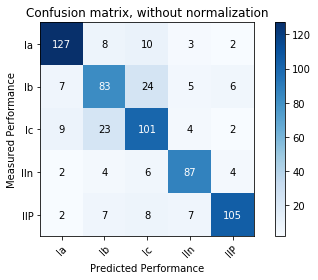

In [21]:
plot_confusion_matrix(array(np.argmax(test_Y, axis=1)), array(y_pred), classes=array(['Ia', 'Ib', 'Ic', 'IIn', 'IIP']), title='Confusion matrix, without normalization')